## Imports

In [193]:
import pandas as pd
import numpy as np

#sklearn
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.linear_model import LinearRegression, Lasso, LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.feature_selection import RFECV, RFE
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split, StratifiedKFold

#matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

#vis
import altair as alt
alt.renderers.enable('notebook')

nlp = spacy.load('es')

## Load Data From File
## Run through Load_Data.py script first

In [ ]:
post_df = pd.read_csv("./Data/cleaned_data.csv")

## Review the output of the keyword-based crime type classifier first

In [27]:
crimeTypeGroups = post_df.groupby("Crime Type") 
crimeTypeGroups.size()

Crime Type
Disappearance     127
Drugs               9
Extortion          13
Homicide           20
Kidnapping          5
Noncriminal      3264
Rape               30
Robbery           295
Shared Link       240
Violence          124
dtype: int64

In [28]:
statsTemp = post_df.groupby(["Group","Crime Type"]) 
statsTemp.size()

Group                Crime Type   
AlertaHuixquiluca    Disappearance      4
                     Extortion          1
                     Homicide           2
                     Noncriminal      174
                     Robbery            2
                     Violence           3
Atizapa              Noncriminal       37
                     Robbery            4
                     Violence           1
DenunciaChimalhuaca  Disappearance      1
                     Drugs              1
                     Extortion          1
                     Homicide           1
                     Noncriminal       93
                     Robbery            9
                     Violence           4
DenunciaenEdoMe      Disappearance     25
                     Drugs              2
                     Extortion          4
                     Homicide           3
                     Kidnapping         1
                     Noncriminal      391
                     Rape               1

In [ ]:
alt.Chart(crime_post_df.loc[:,["Group", "Vertex", "Crime Type"]]).mark_bar().encode(
    x='count(Vertex)',
    y='Group',
    color=alt.Color('Crime Type'),
    order=alt.Order("Crime Type",'count',sort='descending'),
).properties(
    title="Post Types by Group",
    height=400, 
    width=700
)

In [ ]:
crimeVsNonDisplayDF = post_df.loc[:,["Month", "Vertex", "Crime Type", "Group"]]
crimeVsNonDisplayDF["Crime Type"] = crimeVsNonDisplayDF["Crime Type"].apply(lambda x: "Other" if x in ["Noncriminal", "Shared Link"]\
                                                                            else "Crime")
base = alt.Chart(crimeVsNonDisplayDF).mark_bar().encode(
    y='count(Vertex)',
    x=alt.X('Month', sort=["Jan","Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]),
    color=alt.Color('Crime Type')
).properties(
    width=150,
    height=100
)

#create a list of subplots
subplts = []
for grp in crimeVsNonDisplayDF['Group'].unique():
    subplts.append(base.transform_filter(alt.datum.Group == grp).properties(title= grp))


def facet_wrap(subplts, plots_per_row):
    rows = [subplts[i:i+plots_per_row] for i in range(0, len(subplts), plots_per_row)]
    compound_chart = alt.hconcat()
    for r in rows:
        rowplot = alt.vconcat() #start a new row
        for item in r:
            rowplot |= item #add suplot to current row as a new column
        compound_chart &= rowplot # add the entire row of plots as a new row
    return compound_chart


compound_chart = facet_wrap(subplts, plots_per_row=4)    
compound_chart

## Try a classifier to get better accuracy

In [ ]:
goldFeatures = post_df[post_df["Label_Id"].isin([0,1,2,3,4,5,6])]
goldFeatures = goldFeatures.drop(["Vertex", "Popularity Measure", "Total Likes", "Total Shares", "Total Comments",
                       "Month", "Type", "Date", "Post Id", "Gold_Crime_Type_Label", "Text", "Crime Type"], axis=1)
goldX = goldFeatures.drop(["Label_Id", "Group"],axis=1)
goldY = goldFeatures.loc[:,"Label_Id"]

In [203]:
#MNB classifier to get important features per cluster
feature_names = np.array(goldX.columns.values)
clfGB = GradientBoostingClassifier(n_estimators = 200, max_depth=2, random_state=120)
clfGB.fit(goldX, goldY)
print "accuracy: " + str(clfGB.score(goldX, goldY))

accuracy: 0.9791376912378303


### There are likely too many classes and not enough data. Also the class imbalance causes the model to always predict noncriminal

In [194]:
#K-Fold Evaluation
for train, test in StratifiedKFold(2).split(goldX, goldY):
    clfGB.fit(goldX.iloc[train,:], goldY.iloc[train])
    predictedK = clfGB.predict(goldX.iloc[test,:])
    print "accuracy: " + str(metrics.accuracy_score(goldY.iloc[test], predictedK))
    print metrics.confusion_matrix(goldY.iloc[test], predictedK)

accuracy: 0.7285318559556787
[[ 42   5   0   0   0   0  15]
 [  3  11   0   0   0   0  19]
 [  0   0   0   0   0   0   1]
 [  0   0   0   0   0   1   0]
 [  2   0   0   0   1   1   9]
 [  2   1   0   0   0   0   6]
 [  7  18   0   0   5   3 209]]
accuracy: 0.7569832402234636
[[ 47   3   0   0   2   0   9]
 [  0   5   0   0   0   0  28]
 [  0   0   0   0   0   0   1]
 [  0   1   0   0   0   0   0]
 [  3   1   0   0   1   0   7]
 [  0   0   0   0   0   3   5]
 [ 10  12   0   0   3   2 215]]


## Review locations that are predictive overall, and for each class
### NGRAM_ indicates that this term is in the post text
### COMMENT_ indicates that this term is in the comments

In [93]:
topTermLocs = np.argsort(clfGB.feature_importances_)[::-1][:40]
topTerms = ", ".join(feature_names[topTermLocs])
print topTerms

NGRAM_robar, NGRAM_placa, Has Image, COMMENT_defender, COMMENT_amigar, NGRAM_camioneta, COMMENT_policias, NGRAM_denunciar, NGRAM_compartir, COMMENT_abusar, NGRAM_dejar, NGRAM_dinero, COMMENT_mesar, NGRAM_hash, COMMENT_hijo, NGRAM_favor, COMMENT_alos, NGRAM_localizar, NGRAM_coacalco, NGRAM_color, COMMENT_agarrar, NGRAM_edad, NGRAM_pagar, NGRAM_por favor, COMMENT_jaja, NGRAM_violencia, COMMENT_autoridad, COMMENT_esto, COMMENT_onda, NGRAM_las, NGRAM_madre, NGRAM_vestir, NGRAM_asaltar, NGRAM_llamar, NGRAM_ecatepec, NGRAM_personar, COMMENT_asi, COMMENT_andar, NGRAM_llegar, NGRAM_vida


In [82]:
for i, label in enumerate(["Robbery", "Disappearance", "Homicide",
                   "Violence", "Extortion", "Noncriminal"]):
    topTermLocs = np.argsort(clfGB.coef_[i])[::-1][:20]
    topTerms = ", ".join(feature_names[topTermLocs])
    print("%s: %s" % (label, topTerms))

Robbery: NGRAM_asaltar, NGRAM_robar, NGRAM_placa, NGRAM_acabar, NGRAM_armar, NGRAM_color, NGRAM_auto, NGRAM_mensaje, NGRAM_noche, NGRAM_calle, NGRAM_camioneta, NGRAM_una, NGRAM_llevar, NGRAM_zona, NGRAM_denunciar, NGRAM_tipo, NGRAM_con, NGRAM_estado xico, NGRAM_cuidar, COMMENT_jajajaja
Disappearance: NGRAM_amigo, NGRAM_vestir, NGRAM_edad, NGRAM_marzo, NGRAM_salir, NGRAM_localizar, COMMENT_dios, NGRAM_ecatepec, Has Image, NGRAM_nombrar, NGRAM_tipo, NGRAM_informaci, NGRAM_regresar, NGRAM_negro, NGRAM_nos, NGRAM_familiar, NGRAM_menor, NGRAM_solicitar, NGRAM_favor, NGRAM_publicar
Homicide: NGRAM_hash, NGRAM_vida, NGRAM_personar, NGRAM_mesar, NGRAM_con, NGRAM_madre, NGRAM_coacalco, NGRAM_pagar, COMMENT_defender, NGRAM_por favor, NGRAM_compartir, NGRAM_por, COMMENT_polic, COMMENT_andar, NGRAM_favor, COMMENT_osea, COMMENT_resultar, COMMENT_policias, COMMENT_aparecer, COMMENT_garcia
Violence: NGRAM_violencia, NGRAM_personar, NGRAM_unidad, NGRAM_las, NGRAM_hijo, NGRAM_edad, NGRAM_poder, NGRAM_a

## Trimming features results in a slightly more compact explanation for each term, if not a better model

/anaconda/lib/python2.7/site-packages/sklearn/model_selection/_split.py:597: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
/anaconda/lib/python2.7/site-packages/sklearn/utils/__init__.py:93: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Optimal number of features : 470


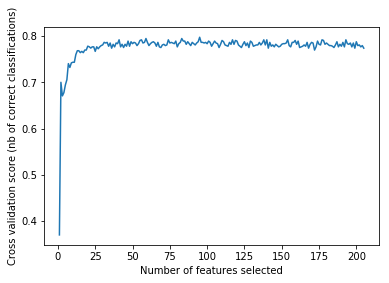

In [94]:
rfecv = RFECV(estimator=clfGB, step=5, cv=StratifiedKFold(3),
              scoring='accuracy')
rfecv.fit(goldX, goldY)
print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [95]:
rfe = RFE(estimator=clfGB, step=10, n_features_to_select = 470)
rfe.fit(goldX, goldY)
#list of retained features
kept_features = rfe.get_support(indices=True)
zip(goldX.iloc[:,kept_features].columns.values, list(rfe.estimator_.feature_importances_.reshape(-1)))

[('Has Image', 0.016838410310518095),
 ('Total Likes', 0.0034657724235323335),
 ('Total Shares', 0.004530721982439977),
 ('Total Comments', 0.0025972116236845743),
 ('num_words', 0.0062741749875445925),
 ('avg_word_length', 0.003194262751981193),
 ('has_url', 0.0005400113982714201),
 (u'NGRAM_abril', 0.0007601453442567413),
 (u'NGRAM_abrir', 0.0011025787502268296),
 (u'NGRAM_acabar', 0.006518716663803417),
 (u'NGRAM_agradecer', 0.0028866469748862113),
 (u'NGRAM_alguien', 0.0021118701555809323),
 (u'NGRAM_altura', 0.0006745862298298491),
 (u'NGRAM_amigo', 0.0026603752336617314),
 (u'NGRAM_ana', 0.0011328974880266509),
 (u'NGRAM_andar', 0.0017986347975011635),
 (u'NGRAM_apoyar', 0.0014159918115176676),
 (u'NGRAM_armar', 0.0035596531314213377),
 (u'NGRAM_asaltar', 0.00971991308872941),
 (u'NGRAM_auto', 0.0031469735527564478),
 (u'NGRAM_autoridad', 0.003226719157659515),
 (u'NGRAM_avenir', 0.000353862272516824),
 (u'NGRAM_ayudar', 0.005253362061410063),
 (u'NGRAM_bajar', 0.0012236299528093

In [97]:
#MNB classifier to get important features per cluster
feature_names = np.array(goldX.iloc[:,kept_features].columns.values)
clfGB = GradientBoostingClassifier(n_estimators = 200, max_depth=2, random_state=120)
clfGB.fit(goldX.iloc[:,kept_features], goldY)
print "accuracy: " + str(clfGB.score(goldX.iloc[:,kept_features], goldY))

accuracy: 0.9428172942817294


In [98]:
for i, label in enumerate(["Robbery", "Disappearance", "Homicide",
                   "Violence", "Extortion", "Noncriminal"]):
    topTermLocs = np.argsort(clfGB.coef_[i])[::-1][:20]
    topTerms = ", ".join(feature_names[topTermLocs])
    print("%s: %s" % (label, topTerms))

Robbery: NGRAM_asaltar, NGRAM_robar, NGRAM_placa, NGRAM_acabar, NGRAM_armar, NGRAM_mensaje, NGRAM_color, NGRAM_auto, NGRAM_una, NGRAM_camioneta, NGRAM_calle, NGRAM_noche, NGRAM_llevar, NGRAM_zona, NGRAM_denunciar, NGRAM_tipo, NGRAM_con, NGRAM_violencia, NGRAM_estado xico, COMMENT_jajajaja
Disappearance: NGRAM_amigo, NGRAM_vestir, NGRAM_edad, NGRAM_localizar, NGRAM_marzo, NGRAM_salir, NGRAM_informaci, Has Image, COMMENT_dios, NGRAM_nombrar, NGRAM_ecatepec, NGRAM_familiar, NGRAM_tipo, NGRAM_negro, NGRAM_ayudar, NGRAM_regresar, NGRAM_solicitar, NGRAM_menor, NGRAM_favor, NGRAM_las
Homicide: NGRAM_hash, NGRAM_personar, NGRAM_con, NGRAM_mesar, NGRAM_madre, NGRAM_vida, NGRAM_coacalco, COMMENT_defender, NGRAM_pagar, NGRAM_por favor, COMMENT_polic, NGRAM_compartir, COMMENT_andar, NGRAM_por, COMMENT_osea, COMMENT_policias, COMMENT_resultar, COMMENT_aparecer, COMMENT_garcia, COMMENT_alos
Violence: NGRAM_violencia, NGRAM_unidad, NGRAM_las, NGRAM_personar, NGRAM_edad, NGRAM_hijo, NGRAM_sacar, NGRAM

## Now try predicting Disappearance vs Rest, as this is an easier problem and also the new focus of the project

In [ ]:
goldFeatures = post_df.query("Gold_Disappearance_Label.notnull()")
goldFeatures = goldFeatures.drop(["Vertex", "Popularity Measure", "Total Likes", "Total Shares", "Total Comments",
                       "Month", "Type", "Date", "Post Id", "Gold_Crime_Type_Label", "Text", "Crime Type"], axis=1)
goldX = goldFeatures.drop(["Gold_Disappearance_Label", "Group"],axis=1)
goldY = goldFeatures.loc[:,"Gold_Disappearance_Label"]

In [215]:
clsfFeatures = LogisticRegression(class_weight="balanced", C=5)
clsf = MLPClassifier(solver="lbfgs")

rfe = RFE(estimator=clsfFeatures, step=1, n_features_to_select = 40)
rfe.fit(goldX, goldY)
#list of retained features
kept_feature_ids = rfe.get_support(indices=True)
kept_features = np.array(goldX.iloc[:,kept_feature_ids].columns.values)
print kept_features

['Person in Image' 'Outdoors in Image' u'POST_acabar' u'POST_amigo'
 u'POST_blico' u'POST_callar' u'POST_ciudad' u'POST_dejar' u'POST_edad'
 u'POST_escuela' u'POST_febrero' u'POST_gente' u'POST_goo' u'POST_gracia'
 u'POST_hoy' u'POST_julio' u'POST_localizar' u'POST_pagar' u'POST_pasar'
 u'POST_placa' u'POST_por' u'POST_salir' u'POST_san' u'POST_subir'
 u'POST_vestir' u'COMMENT_ayudar' u'COMMENT_buscar' u'COMMENT_dios'
 u'COMMENT_gente' u'COMMENT_jajaja' u'COMMENT_madre' u'COMMENT_mira'
 u'COMMENT_personar' u'COMMENT_puto' u'IMAGE_1 smiling'
 u'IMAGE_1 standing' u'IMAGE_meme' u'IMAGE_shoes text' u'IMAGE_sitting'
 u'IMAGE_smiling text']


In [216]:
#K-Fold Evaluation
precisions = []
recalls = []
accuracies = []
for train, test in StratifiedKFold(10).split(goldX.loc[:,kept_features], goldY):
    clsf.fit(goldX.loc[:,kept_features].iloc[train,:], goldY.iloc[train])
    predictedK = clsf.predict(goldX.loc[:,kept_features].iloc[test,:])
    precisions.append(metrics.precision_score(goldY.iloc[test], predictedK))
    recalls.append(metrics.recall_score(goldY.iloc[test], predictedK))
    accuracies.append(metrics.accuracy_score(goldY.iloc[test], predictedK))

print np.mean(precisions)
print np.mean(recalls)
print np.mean(accuracies)

0.847564935064935
0.8625
0.9666036936994875


In [65]:
goldFeatures["Prediction"] = clsf.predict(goldFeatures.loc[:,kept_features])

### Investigate ids that were predicted incorrectly

In [66]:
goldFeatures["Wrong Prediction"] = goldFeatures.apply(\
                                       lambda x: x["Gold_Disappearance_Label"] is not None
                                       and x["Prediction"] != x["Gold_Disappearance_Label"],\
                                       axis=1)
wrong_df = goldFeatures[goldFeatures["Wrong Prediction"]].copy()
wrongGroups = wrong_df.groupby(["Gold Label", "Prediction"]) 
print wrongGroups.size()
print wrong_df.shape

Gold Label  Prediction
0.0         1.0           6
1.0         0.0           6
dtype: int64
(12, 490)
